# Uncapacitated Lot-Sizing Problem
The problem is to decide a production plan for a $n$-period horizon for a single product.

The basic model can be viewed as having data:
- $d_t$ the demand in period $t$
- $f_t$ the fixed production cost in period $t$
- $p_t$ the unit production cost in period $t$
- $h_t$ the unit storage cost in period $t$

The production plan must satisfy the demand with a minimum cost.

In [423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, Dropdown


def read_data(file_name: str, keys: list) -> pd.DataFrame:
    df = pd.read_table(file_name, sep=" ", header = None).T
    df.columns = keys
    df.index = range(1, df.shape[0] + 1)
    return df

def transform_df_into_dict(df: pd.DataFrame) -> dict:
    n = df.shape[0]
    data = df.to_dict()
    data['n'] = {None:n}
    return data

FILE_PATH = "data/"
FILE_NAME = "instance_0005.dat"
KEYS = ["d", "f", "p", "h"]

df = read_data(FILE_PATH + FILE_NAME, KEYS)
data = transform_df_into_dict(df)


# def read_data(file_name: str, keys: list) -> dict:
#     n = None
#     data = {}
#     with open(file_name) as file:
#         for index, line in enumerate(file):
#             line_content = list(map(int, line.split()))
#             if n is None:
#                 n = len(line_content)
#                 data['n'] = {None:n}
#             data[keys[index]] = dict(zip(range(1, n+1), line_content))
#     return data

# data = read_data(FILE_PATH + FILE_NAME, KEYS)

In [425]:
data

{'d': {1: 7, 2: 2, 3: 3, 4: 4, 5: 2},
 'f': {1: 10, 2: 11, 3: 13, 4: 15, 5: 9},
 'p': {1: 3, 2: 2, 3: 7, 4: 2, 5: 3},
 'h': {1: 1, 2: 2, 3: 2, 4: 1, 5: 2},
 'n': {None: 5}}

In [426]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverResults
import os

def create_instance(model: pyo.AbstractModel, data: dict) -> pyo.ConcreteModel:
    """Creates a Pyomo instance for a given Pyomo abstract model and a data dictionary"""
    return model.create_instance(data = {None:data})

def solve_instance_locally(instance: pyo.ConcreteModel, solver_name: str = "cplex") -> SolverResults:
    """Solves a Pyomo instance locally"""
    solver = pyo.SolverFactory(solver_name)
    result = solver.solve(instance)
    return result

def solve_instance_externally(instance: pyo.ConcreteModel, email: str, solver_name: str = "cplex", load: bool = True) -> SolverResults:
    """Solves a Pyomo instance on the NEOS servers"""
    os.environ["NEOS_EMAIL"] = email
    solver_manager = pyo.SolverManagerFactory('neos')
    result = solver_manager.solve(instance, opt=solver_name, load_solutions=load)
    return result

## Integer Linear Programming Formulation 1

The variables :
- $x_t$ the number of items produced in period $t$, $\forall t \in \{1,\dots,n\}$
- $y_t = 1$ if production occurs in period $t$, otherwise $y_t = 0$, $\forall t \in \{1,\dots,n\}$
- $s_t$ the number of items stored at the end of period $t$, $\forall t \in \{0,\dots,n\}$

The model :

$\begin{cases}
    \text{Minimize} \sum_{t=1}^{n} f_t y_t + \sum_{t=1}^{n} p_t x_t + \sum_{t=1}^{n} h_t s_t \\
    s_{t-1} + x_t = d_t + s_t & \forall t \in \{1,\dots,n\}\\
    x_t \le M_t y_t & \forall t \in \{1,\dots,n\}\\
    y_t \in \{0, 1\} & \forall t \in \{1,\dots,n\}\\
    x_t, s_t \ge 0 & \forall t \in \{1,\dots,n\}\\
    s_0 = 0
\end{cases}$

With :
- $M_t = \sum_{k=t}^n d_k$ an upperbound of $M_t$

In [427]:
# Setting up the big M
data['M'] = {t:sum(list(data['d'].values())[t-1:]) for (t, value) in data['d'].items()}
data['s0'] = {None:0}

In [428]:
def create_uls_1_abstract_model() -> pyo.AbstractModel:
    """Creates a Pyomo abstract model for ULS 1"""
    model = pyo.AbstractModel()

    # immutable parameters
    model.n = pyo.Param(domain = pyo.NonNegativeIntegers)

    # sets
    model.N = pyo.RangeSet(1, model.n)
    model.S = pyo.RangeSet(0, model.n)

    # mutable parameters
    model.s0 = pyo.Param(domain = pyo.NonNegativeIntegers, mutable = True)

    model.d = pyo.Param(model.N, domain = pyo.NonNegativeIntegers, mutable = True)
    model.f = pyo.Param(model.N, domain = pyo.NonNegativeIntegers, mutable = True)
    model.p = pyo.Param(model.N, domain = pyo.NonNegativeIntegers, mutable = True)
    model.h = pyo.Param(model.N, domain = pyo.NonNegativeIntegers, mutable = True)

    model.M = pyo.Param(model.N, mutable = True)
    
    # variables
    model.x = pyo.Var(model.N, domain = pyo.NonNegativeIntegers)
    model.s = pyo.Var(model.S, domain = pyo.NonNegativeIntegers)
    model.y = pyo.Var(model.N, domain = pyo.Binary)
    
    # objective function
    model.objective = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # constraints
    model.conservation_constraint  = pyo.Constraint(model.N, rule = conservation_rule)
    model.big_m_constraint         = pyo.Constraint(model.N, rule = big_m_rule)
    model.initial_stock_constraint = pyo.Constraint(rule = initial_stock_rule)
    
    return model

def objective_rule(model: pyo.AbstractModel) -> pyo.Expression:
    return sum(model.f[t] * model.y[t] + \
               model.p[t] * model.x[t] + \
               model.h[t] * model.s[t] for t in model.N)

def conservation_rule(model: pyo.AbstractModel, t: int) -> pyo.Expression:
    """Conservation rule for ULS 1"""
    return model.s[t-1] + model.x[t] == model.d[t] + model.s[t]

def big_m_rule(model: pyo.AbstractModel, t: int) -> pyo.Expression:
    """Big M rule for ULS 1"""
    return model.x[t] <= model.M[t] * model.y[t]

def initial_stock_rule(model: pyo.AbstractModel) -> pyo.Expression:
    """Initial Stock rule for ULS 1"""
    return model.s[0] == model.s0

In [429]:
uls_1 = create_uls_1_abstract_model()
uls_1_instance = create_instance(uls_1, data)
result = solve_instance_locally(uls_1_instance, "cplex")

In [430]:
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpthfp0l5i
  Lower bound: 86.0
  Upper bound: 86.0
  Number of objectives: 1
  Number of constraints: 12
  Number of variables: 17
  Number of nonzeros: 27
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.02
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 8.6000000000e+01
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.10030364990234375
# -------------

In [170]:
#x = {t:int(uls_1_instance.x[t].value) for t in range(1, n+1)}
#s = {t:int(uls_1_instance.s[t].value) for t in range(1, n+1)}
#y = {t:int(uls_1_instance.y[t].value) for t in range(1, n+1)}

In [259]:
df['x'] = [int(uls_1_instance.x[t].value) for t in range(1, n+1)]
df['s'] = [int(uls_1_instance.s[t].value) for t in range(1, n+1)]
df['y'] = [int(uls_1_instance.y[t].value) for t in range(1, n+1)]

In [260]:
plot_lines(df)

In [302]:
def plot_columns(df):
    #sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(df.columns)))
    
    for i, column in enumerate(df.columns):
        ax.plot(df.index, df[column], label=column, color=colors[i], linewidth=1, marker='o', markersize=8)

    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Plot of DataFrame Columns')

    ax.legend()
    plt.show()

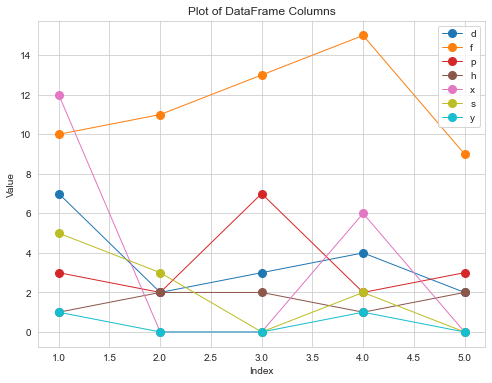

In [303]:
plot_columns(df)

In [144]:
def main():
    uls_1 = create_uls_1_abstract_model()
    uls_1_instance = create_instance(uls_1, data)
    result = solve_instance_locally(uls_1_instance, "cplex")
    # email = "brahim.mebrek.pro@gmail.com"
    # result = solve_instance_externally(uls_1_instance, email = email, solver_name = 'cplex')
    print(result)

if __name__ == "__main__":
    main()


Problem: 
- Name: tmpbxj_01yd
  Lower bound: 2527.0
  Upper bound: 2527.0
  Number of objectives: 1
  Number of constraints: 202
  Number of variables: 302
  Number of nonzeros: 502
  Sense: minimize
Solver: 
- Status: ok
  User time: 0.06
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 2.5270000000e+03
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.16553759574890137
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [229]:
for t, v in data['f'].items():
    data['f'][t] += 30

In [231]:
uls_1_2 = create_uls_1_abstract_model()
uls_1_2_instance = create_instance(uls_1_2, data)
result = solve_instance_locally(uls_1_2_instance, "cplex")

In [233]:
df['x_2'] = [int(uls_1_2_instance.x[t].value) for t in range(1, n+1)]
df['s_2'] = [int(uls_1_2_instance.s[t].value) for t in range(1, n+1)]
df['y_2'] = [int(uls_1_2_instance.y[t].value) for t in range(1, n+1)]

In [234]:
df

,d,f,p,h,x,s,y,x_2,s_2,y_2
1,7,10,3,1,12,5,1,18,11,1
2,2,11,2,2,0,3,0,0,9,0
3,3,13,7,2,0,0,0,0,6,0
4,4,15,2,1,6,2,1,0,2,0
5,2,9,3,2,0,0,0,0,0,0


In [ ]:
def plot_lines(df, mode = 'lines+markers'):
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index, y=df[col].values, name=col,  mode=mode))

    fig.update_layout(width = 950, height = 400)
    fig.show();